In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Changing the directory to data2 folder**

In [2]:
import os
os.chdir("./data")

### Importing Necessary Modules 

In [3]:

import tensorflow as tf
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import cv2



### Creating a Function to plot images 

In [4]:
### defining some function to make our work easier
import matplotlib.pyplot as plt

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plot_images(images_arr, imageWidth, imageHeight):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.reshape(imageWidth, imageHeight), cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()


##### Some constants to be defined 

In [5]:
batch_size = 32
epochs = 50
IMG_HEIGHT = 28
IMG_WIDTH = 28

### Image Data Generator 
We defined two data generators, one that augments the data to make our training more general and one that just scales and centers the data.

In [6]:
def preprocessing_fun(img):
#     print(img.shape)
#     print(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY, CV_8UC1)
    img = cv2.GaussianBlur(img,(3,3),0)
    img = img.reshape((28,28,1))
    thresh = cv2.adaptiveThreshold(img, 255, 1, 1, 11, 2)
    print(thresh.shape)
    

#     img = img.reshape((28,28,1))

#     img = np.where(img>140,1,0)
#     img  = img/255
#     return img

In [7]:
augmented_image_gen = ImageDataGenerator(
        rescale = 1/255.0,
    rotation_range=2,
    width_shift_range=.1,
    height_shift_range=.1,
    zoom_range=0.1,
    shear_range=2,
    brightness_range=[0.9, 1.1],
    validation_split=0.2,
   
   )

normal_image_gen = ImageDataGenerator(
    rescale = 1/255.0,
    validation_split=0.2,
  
   )


#### Using Data Generator generate batches to train our model

In [8]:
train_data_gen = augmented_image_gen.flow_from_directory(batch_size=batch_size,
                                                     directory="./training_data",
                                                     color_mode="grayscale",
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical",
                                                     seed=65657867,
                                                     subset='training')
val_data_gen = normal_image_gen.flow_from_directory(batch_size=batch_size,
                                                     directory="./testing_data",
                                                     color_mode="grayscale",
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical",
                                                     seed=65657867,
                                                     subset='validation')


Found 16524 images belonging to 36 classes.
Found 180 images belonging to 36 classes.


#### samples

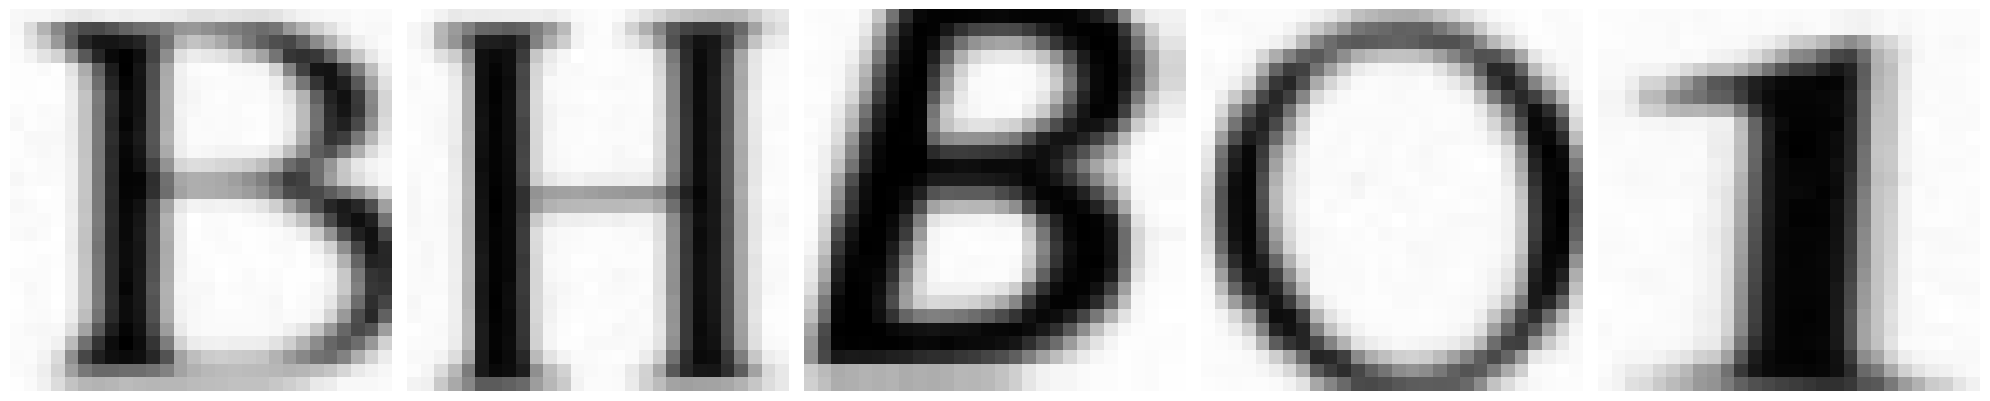

In [9]:
sample_training_images, _ = next(train_data_gen)
plot_images(sample_training_images[:7], IMG_WIDTH, IMG_HEIGHT)

### Defining our Sequential model 

In [10]:
# model = Sequential([
#     Conv2D(16, 3, 
#            padding='same',
#            activation='relu',
#            kernel_regularizer=regularizers.l2(0.0001),
#            input_shape=(IMG_HEIGHT, IMG_WIDTH , 1)),
#     MaxPooling2D(),
#     Dropout(0.2),
#     Flatten(),
#     Dense(
#         50,
#         activation='relu',
#         kernel_regularizer=regularizers.l2(0.0001)
#     ),
#     Dropout(0.2),
#     Dense(36, activation='softmax')
# ])

from tensorflow.keras.optimizers import SGD
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(36, activation='softmax'))
    return model
#     # compile model
# 	opt = SGD(lr=0.01, momentum=0.9)
# 	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# 	return model

In [11]:
model = define_model()

In [12]:
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
#Prepare call backs
EarlyStop_callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint('/kaggle/working/checkpoint',
                             monitor = 'val_loss',mode = 'min',save_best_only= True)
lr = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.5,patience = 3,min_lr = 0.00001)
my_callback=[EarlyStop_callback,checkpoint]

### Actual training of our model

In [13]:
model.compile(optimizer=SGD(lr=0.01, momentum=0.9),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=32,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
    callbacks = my_callback)

C:\Users\olami\AppData\Local\Temp\ipykernel_14592\2607022695.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/32
516/516 [==============================] - ETA: 0s - loss: 3.0718 - categorical_accuracy: 0.1077INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


516/516 [==============================] - 168s 325ms/step - loss: 3.0718 - categorical_accuracy: 0.1077 - val_loss: 1.7990 - val_categorical_accuracy: 0.3750
Epoch 2/32
516/516 [==============================] - ETA: 0s - loss: 1.3602 - categorical_accuracy: 0.5859INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


516/516 [==============================] - 19s 37ms/step - loss: 1.3602 - categorical_accuracy: 0.5859 - val_loss: 0.2472 - val_categorical_accuracy: 0.9250
Epoch 3/32
515/516 [============================>.] - ETA: 0s - loss: 0.6140 - categorical_accuracy: 0.8289INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


516/516 [==============================] - 19s 37ms/step - loss: 0.6138 - categorical_accuracy: 0.8290 - val_loss: 0.1681 - val_categorical_accuracy: 0.9375
Epoch 4/32
516/516 [==============================] - ETA: 0s - loss: 0.4393 - categorical_accuracy: 0.8714INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


516/516 [==============================] - 19s 37ms/step - loss: 0.4393 - categorical_accuracy: 0.8714 - val_loss: 0.0884 - val_categorical_accuracy: 0.9625
Epoch 5/32
516/516 [==============================] - ETA: 0s - loss: 0.3656 - categorical_accuracy: 0.8956INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


516/516 [==============================] - 19s 37ms/step - loss: 0.3656 - categorical_accuracy: 0.8956 - val_loss: 0.0846 - val_categorical_accuracy: 0.9688
Epoch 6/32
516/516 [==============================] - 18s 34ms/step - loss: 0.3178 - categorical_accuracy: 0.9109 - val_loss: 0.1191 - val_categorical_accuracy: 0.9438
Epoch 7/32
515/516 [============================>.] - ETA: 0s - loss: 0.3016 - categorical_accuracy: 0.9148INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


516/516 [==============================] - 19s 36ms/step - loss: 0.3014 - categorical_accuracy: 0.9149 - val_loss: 0.0748 - val_categorical_accuracy: 0.9812
Epoch 8/32
515/516 [============================>.] - ETA: 0s - loss: 0.2775 - categorical_accuracy: 0.9185INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


516/516 [==============================] - 20s 38ms/step - loss: 0.2771 - categorical_accuracy: 0.9186 - val_loss: 0.0549 - val_categorical_accuracy: 0.9750
Epoch 9/32
516/516 [==============================] - 19s 38ms/step - loss: 0.2492 - categorical_accuracy: 0.9241 - val_loss: 0.1022 - val_categorical_accuracy: 0.9563
Epoch 10/32
516/516 [==============================] - 19s 37ms/step - loss: 0.2530 - categorical_accuracy: 0.9223 - val_loss: 0.0678 - val_categorical_accuracy: 0.9688
Epoch 11/32
516/516 [==============================] - 18s 36ms/step - loss: 0.2392 - categorical_accuracy: 0.9291 - val_loss: 0.0973 - val_categorical_accuracy: 0.9563
Epoch 12/32
515/516 [============================>.] - ETA: 0s - loss: 0.2288 - categorical_accuracy: 0.9333INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


516/516 [==============================] - 20s 39ms/step - loss: 0.2286 - categorical_accuracy: 0.9333 - val_loss: 0.0490 - val_categorical_accuracy: 0.9750
Epoch 13/32
516/516 [==============================] - ETA: 0s - loss: 0.2213 - categorical_accuracy: 0.9314INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


516/516 [==============================] - 20s 38ms/step - loss: 0.2213 - categorical_accuracy: 0.9314 - val_loss: 0.0423 - val_categorical_accuracy: 0.9750
Epoch 14/32
516/516 [==============================] - 19s 36ms/step - loss: 0.2114 - categorical_accuracy: 0.9349 - val_loss: 0.0659 - val_categorical_accuracy: 0.9688
Epoch 15/32
516/516 [==============================] - ETA: 0s - loss: 0.2094 - categorical_accuracy: 0.9350INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


516/516 [==============================] - 20s 38ms/step - loss: 0.2094 - categorical_accuracy: 0.9350 - val_loss: 0.0415 - val_categorical_accuracy: 0.9750
Epoch 16/32
516/516 [==============================] - 24s 46ms/step - loss: 0.1964 - categorical_accuracy: 0.9417 - val_loss: 0.0571 - val_categorical_accuracy: 0.9688
Epoch 17/32
516/516 [==============================] - 36s 71ms/step - loss: 0.1904 - categorical_accuracy: 0.9404 - val_loss: 0.0704 - val_categorical_accuracy: 0.9625
Epoch 18/32
516/516 [==============================] - 37s 71ms/step - loss: 0.1885 - categorical_accuracy: 0.9404 - val_loss: 0.0506 - val_categorical_accuracy: 0.9750
Epoch 19/32
516/516 [==============================] - 44s 84ms/step - loss: 0.1852 - categorical_accuracy: 0.9416 - val_loss: 0.0589 - val_categorical_accuracy: 0.9688
Epoch 20/32
516/516 [==============================] - 46s 89ms/step - loss: 0.1798 - categorical_accuracy: 0.9449 - val_loss: 0.0764 - val_categorical_accuracy: 0.956

INFO:tensorflow:Assets written to: /kaggle/working\checkpoint\assets


516/516 [==============================] - 19s 37ms/step - loss: 0.1617 - categorical_accuracy: 0.9476 - val_loss: 0.0362 - val_categorical_accuracy: 0.9812
Epoch 28/32
516/516 [==============================] - 19s 37ms/step - loss: 0.1588 - categorical_accuracy: 0.9499 - val_loss: 0.0644 - val_categorical_accuracy: 0.9688
Epoch 29/32
516/516 [==============================] - 19s 37ms/step - loss: 0.1554 - categorical_accuracy: 0.9484 - val_loss: 0.0426 - val_categorical_accuracy: 0.9750
Epoch 30/32
516/516 [==============================] - 19s 37ms/step - loss: 0.1459 - categorical_accuracy: 0.9538 - val_loss: 0.0529 - val_categorical_accuracy: 0.9750
Epoch 31/32
516/516 [==============================] - 19s 38ms/step - loss: 0.1527 - categorical_accuracy: 0.9491 - val_loss: 0.0404 - val_categorical_accuracy: 0.9812
Epoch 32/32
516/516 [==============================] - 18s 35ms/step - loss: 0.1523 - categorical_accuracy: 0.9514 - val_loss: 0.0497 - val_categorical_accuracy: 0.975

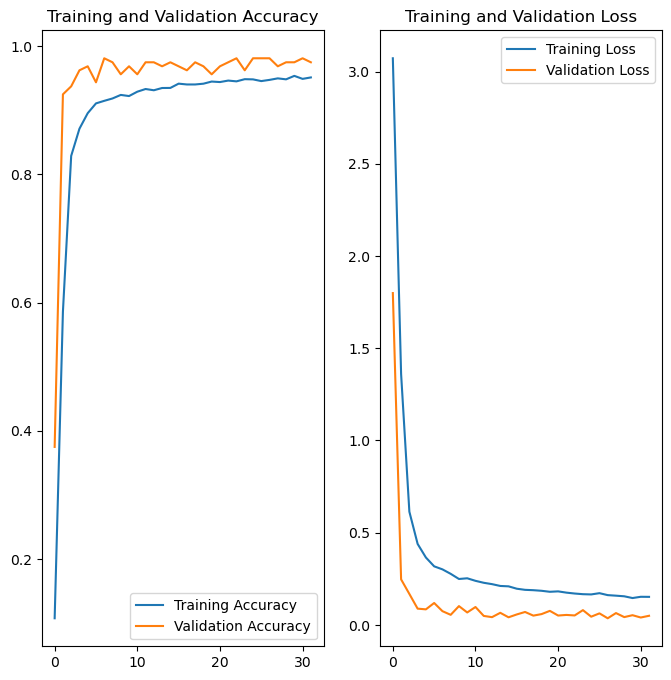

In [14]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']



val_loss = history.history['val_loss']

epochs_range = range(32)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Test our Model

In [15]:
normal_image_gen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True
)
test_data_gen = normal_image_gen.flow_from_directory(batch_size=5193,
                                                     directory="./testing_data",
                                                     color_mode="grayscale",
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical")

Found 1008 images belonging to 36 classes.


In [16]:
from PIL import Image
test_images, test_labels = next(test_data_gen)
filenames = test_data_gen.filenames
test_pred = model.predict(test_images)

32/32 [==============================] - 0s 4ms/step


In [17]:

true_labels = tf.argmax(test_labels,1)

In [18]:
predicted_labels = tf.argmax(test_pred,1)

In [19]:
import sklearn
from sklearn.metrics import confusion_matrix,classification_report

In [20]:
confusion_matrix(true_labels, predicted_labels)

array([[ 1,  0,  0, ...,  0,  0,  0],
       [ 0, 28,  0, ...,  0,  0,  0],
       [ 0,  0, 26, ...,  0,  0,  2],
       ...,
       [ 0,  0,  0, ..., 28,  0,  0],
       [ 0,  0,  0, ...,  0, 28,  0],
       [ 0,  0,  0, ...,  0,  0, 28]], dtype=int64)

In [28]:
img = cv2.imread('testing_data/N/28333.png',0)
img = img/255
img = cv2.resize(img, (28,28))
img = img.reshape((1,28,28,1))

plt.show()

tf.argmax(model.predict(img),1)

1/1 [==============================] - 0s 25ms/step


<tf.Tensor: shape=(1,), dtype=int64, numpy=array([23], dtype=int64)>

### Perfect ! 

this model works well but somehow 0, O is bit confusing for this model as we know

### Save Model

#### Make sure change os.chdir(./data)

In [67]:
# os.chdir('../')

In [70]:

model.save('./saved_model/ocr_model.h5')
# model.save('ocr_model.keras')

In [71]:
from tensorflow.keras.models import load_model

In [72]:
test_model = load_model('saved_model/ocr_model.h5')